In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import layers

In [3]:
IMG_SIZE = 224
CHANNEL = 3
EPOCHS = 10
BATCH_SIZE = 32

In [4]:
train = tf.keras.preprocessing.image_dataset_from_directory("C:\\Users\\jayan\\Desktop\\machinelearningg\\animals\\animals",
                                                           shuffle = True,
                                                           image_size = (224,224),
                                                           batch_size = BATCH_SIZE)

Found 5400 files belonging to 90 classes.


In [5]:
def create_data_batch(dataset,train_size = 0.8,val_size = 0.1,test_size = 0.1,shuffle = True,shuffle_size = 1000):
    data_len = len(dataset)
    if shuffle :
        dataset = dataset.shuffle(shuffle_size , seed = 12)
        
    train_size = int(data_len*train_size)
    val_size = int(data_len * val_size)
    
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)
    
    return train_ds,test_ds,val_ds

In [39]:
len(val_ds),len(train_ds),len(test_ds)

(16, 135, 18)

In [6]:
train_ds,test_ds,val_ds = create_data_batch(train)

In [7]:
class_name = train.class_names

In [8]:
len(class_name)

90

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)


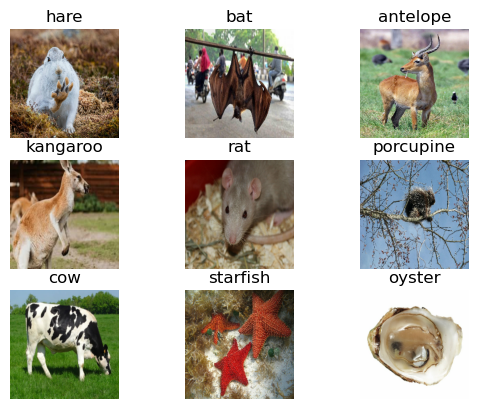

In [10]:
for image,label in train.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_name[label[i]])
        plt.axis('off')

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])


In [12]:
rescale_resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(224,224),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
pre_trained_model=tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top = False,
    weights="imagenet",
    pooling='max',
    classes=4,
    classifier_activation="softmax"
)

for layers in pre_trained_model.layers:
    layers.trainable=False


In [21]:
model = tf.keras.Sequential([
    #CNN
    rescale_resize,
    pre_trained_model,
    keras.layers.Flatten(),
    keras.layers.Dense(150, activation="relu"),
    keras.layers.Dense(90, activation="softmax")
])

model.build((BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNEL))

In [22]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

callbacks = tf.keras.callbacks.EarlyStopping(monitor="acc", patience=2)

In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (32, 1280)                0         
                                                                 
 dense_2 (Dense)             (32, 150)                 192150    
                                                                 
 dense_3 (Dense)             (32, 90)                  13590     
                                                                 
Total params: 2463724 (9.40 MB)
Trainable params: 205740 (803.67 KB)
Non-trainable params: 2257984 (8.61 MB)
___________

In [24]:
history = model.fit(train_ds,validation_data=val_ds,epochs=15)

Epoch 1/15
135/135 [==============================] - 162s 1s/step - loss: 3.6288 - acc: 0.2117 - val_loss: 1.7651 - val_acc: 0.5664
Epoch 2/15
135/135 [==============================] - 121s 900ms/step - loss: 1.2991 - acc: 0.6387 - val_loss: 0.8571 - val_acc: 0.7617
Epoch 3/15
135/135 [==============================] - 122s 907ms/step - loss: 0.7082 - acc: 0.7973 - val_loss: 0.7245 - val_acc: 0.8086
Epoch 4/15
135/135 [==============================] - 74s 549ms/step - loss: 0.4498 - acc: 0.8641 - val_loss: 0.5275 - val_acc: 0.8633
Epoch 5/15
135/135 [==============================] - 72s 534ms/step - loss: 0.2902 - acc: 0.9191 - val_loss: 0.4063 - val_acc: 0.8926
Epoch 6/15
135/135 [==============================] - 72s 530ms/step - loss: 0.1827 - acc: 0.9481 - val_loss: 0.3609 - val_acc: 0.9062
Epoch 7/15
135/135 [==============================] - 71s 529ms/step - loss: 0.1120 - acc: 0.9777 - val_loss: 0.3208 - val_acc: 0.9297
Epoch 8/15
135/135 [==============================] - 7

In [ ]:
from PIL import Image

In [ ]:
model.save('animal_model.h5')

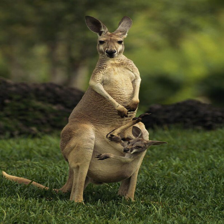

In [48]:
from PIL import Image
img = Image.open('kang1.jpg').resize((224,224))
img

In [49]:
img = tf.keras.preprocessing.image.img_to_array(img)

img = np.expand_dims(img,axis=0)
predicted = model.predict(img)

class_name[np.argmax(predicted)]

1/1 [==============================] - 0s 55ms/step


'kangaroo'

In [37]:
model.evaluate(test_ds)

18/18 [==============================] - 42s 848ms/step - loss: 0.1634 - acc: 0.9635


[0.16335882246494293, 0.9635416865348816]

In [44]:
y_true = []

y_pred = []

for image,label in test_ds:
    for i in range(32):
        img = np.expand_dims(image[i].numpy(),axis=0)
        y_pred.append(np.argmax(model.predict(img)))
        y_true.append(label[i].numpy())

1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 62ms/step


In [45]:
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         6
           6       1.00      0.83      0.91         6
           7       1.00      1.00      1.00         9
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         7
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         8
          13       0.86      1.00      0.92         6
          14       0.89      1.00      0.94         8
          15       1.00      0.88      0.93         8
          16       0.83      1.00      0.91         5
          17       0.80    

In [51]:
model.save('animal_classification.h5')

D:\New folder (2)\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
